In [17]:
import geopandas as gpd
import boto3
from pathlib import Path
import json
import requests
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from rasterio.mask import mask
import rasterio
from shapely.geometry import mapping
import fiona
import rasterio
from osgeo import gdal
from rasterio import features
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
#auth
credentials_path = "/home/eouser/project/credentials.txt"

def parse_creds(credentials_path):
        credentials_file = Path(credentials_path).resolve()
        with open(credentials_file, 'r') as file:
            lines = file.readlines()
       
        access_key = lines[0].strip()
        secret_key = lines[1].strip()
        host='http://eodata.cloudferro.com'
        return [access_key, secret_key, host]

credentials = parse_creds(credentials_path)
s3 = boto3.client('s3',aws_access_key_id = credentials[0], aws_secret_access_key = credentials[1], endpoint_url = credentials[2])

In [3]:
# url = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%202023-08-01T00:00:00.000Z%20and%20ContentDate/Start%20le%202023-08-31T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POLYGON%20((19.697187%2049.343968,%2020.297582%2049.331715,%2020.30497%2049.111082,%2019.653534%2049.110642,%2019.697187%2049.343968))%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27platformSerialIdentifier%27%20and%20i0/Value%20eq%20%27A%27))%20or%20(Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27platformSerialIdentifier%27%20and%20i0/Value%20eq%20%27B%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27orbitDirection%27%20and%20i0/Value%20eq%20%27ASCENDING%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"
url = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%202023-12-01T00:00:00.000Z%20and%20ContentDate/Start%20le%202023-12-30T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POLYGON%20((19.763527%2049.315438,%2020.219198%2049.316286,%2020.217896%2049.118995,%2019.703639%2049.127515,%2019.763527%2049.315438))%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27platformSerialIdentifier%27%20and%20i0/Value%20eq%20%27A%27))%20or%20(Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27platformSerialIdentifier%27%20and%20i0/Value%20eq%20%27B%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"

In [4]:
products = json.loads(requests.get(url).text)
    
path_list = []                           
for item in products['value']:
    path_list.append(item['S3Path'])
    print(item['S3Path'])  

/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/04/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/05/S1A_IW_GRDH_1SDV_20231205T163518_20231205T163543_051522_063819_BB7D_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/09/S1A_IW_GRDH_1SDV_20231209T045340_20231209T045405_051573_0639DA_BE65_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/12/S1A_IW_GRDH_1SDV_20231212T162706_20231212T162731_051624_063BC1_3B4A_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/16/S1A_IW_GRDH_1SDV_20231216T044533_20231216T044558_051675_063D6D_A3D4_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/17/S1A_IW_GRDH_1SDV_20231217T163517_20231217T163542_051697_063E38_980A_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/21/S1A_IW_GRDH_1SDV_20231221T045339_20231221T045404_051748_063FF3_7C01_COG.SAFE
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/24/S1A_IW_GRDH_1SDV_20231224T162705_20231224T162730_051799_0641C7_4AF3_C

In [5]:
for directory_path in path_list:
    print(f"Contents of {directory_path}:")
    matching_directories = glob.glob(os.path.join(directory_path, 'measurement'))

    for directory in matching_directories:
        for root, dirs, files in os.walk(directory):
            for file in files:
                print(os.path.join(root, file))

Contents of /eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/04/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG.SAFE:


/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/04/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG.SAFE/measurement/s1a-iw-grd-vh-20231204t044533-20231204t044558-051500-063751-002-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/04/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG.SAFE/measurement/s1a-iw-grd-vv-20231204t044533-20231204t044558-051500-063751-001-cog.tiff
Contents of /eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/05/S1A_IW_GRDH_1SDV_20231205T163518_20231205T163543_051522_063819_BB7D_COG.SAFE:
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/05/S1A_IW_GRDH_1SDV_20231205T163518_20231205T163543_051522_063819_BB7D_COG.SAFE/measurement/s1a-iw-grd-vh-20231205t163518-20231205t163543-051522-063819-002-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/05/S1A_IW_GRDH_1SDV_20231205T163518_20231205T163543_051522_063819_BB7D_COG.SAFE/measurement/s1a-iw-grd-vv-20231205t163518-20231205t163543-051522-063819-001-cog.tiff
Contents of /eoda

In [6]:
vv_path_list = []
for dir_path_nonoil in path_list:
    matching_dir=glob.glob(os.path.join(dir_path_nonoil, 'measurement'))
    
    for dir in matching_dir:
        for root, dirs, files in os.walk(dir):
            for file in files:
                if file.find('-vv-') != -1:
                    file_path = os.path.join(root, file)
                    vv_path_list.append(file_path)
                    print(file_path)

print(vv_path_list)

/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/04/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG.SAFE/measurement/s1a-iw-grd-vv-20231204t044533-20231204t044558-051500-063751-001-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/05/S1A_IW_GRDH_1SDV_20231205T163518_20231205T163543_051522_063819_BB7D_COG.SAFE/measurement/s1a-iw-grd-vv-20231205t163518-20231205t163543-051522-063819-001-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/09/S1A_IW_GRDH_1SDV_20231209T045340_20231209T045405_051573_0639DA_BE65_COG.SAFE/measurement/s1a-iw-grd-vv-20231209t045340-20231209t045405-051573-0639da-001-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/12/S1A_IW_GRDH_1SDV_20231212T162706_20231212T162731_051624_063BC1_3B4A_COG.SAFE/measurement/s1a-iw-grd-vv-20231212t162706-20231212t162731-051624-063bc1-001-cog.tiff
/eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2023/12/16/S1A_IW_GRDH_1SDV_20231216T044533_20231216T044558_051675_063D6D_A3D4_COG.SAFE/measurement/s1a-iw-grd-vv-2023

In [18]:
for file in vv_path_list:  
    
    kwargs = {'format': 'VRT'}
    gdal.Warp('/tmp/vrt.vrt', file, **kwargs)
    
    shp_file_path = "/home/eouser/project/polygon.gpkg"
    
    array = file.split('/')
    name = f"{array[5]}_{array[6]}_{array[7]}"
    output_raster_path = f'tatras_rasters/mission_{name}_tatra_TC.tif'
    
    with fiona.open(shp_file_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    
    with rasterio.open('/tmp/vrt.vrt') as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})
    
    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)   

SystemError: <built-in function Open> returned a result with an exception set

In [19]:
raster = f"/home/eouser/project/terrain_corrected/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG_OB_CAL_TF_TC_INC.tif"
print(raster)

kwargs = {'format': 'VRT'}
gdal.Warp('/tmp/vrt.vrt', raster, **kwargs)

shp_file_path = "/home/eouser/project/polygon.gpkg"

array = file.split('/')
name = f"december"
output_raster_path = f'tatras_rasters/mission_{name}_tatra_TC.tif'

with fiona.open(shp_file_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Przekształcenie współrzędnych i maskowanie
with rasterio.open('/tmp/vrt.vrt') as src:
    print("Original CRS:", src.crs)
    
    # Określenie nowego układu współrzędnych
    dst_crs = 'EPSG:4326'
    
    # Obliczanie nowego transformu i rozmiaru
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Nowe metadane
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Ścieżka do wynikowego rastra
    output_raster_path = f'tatras_rasters/mission_december_tatra_TC_4326.tif'
    
out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})

with rasterio.open(output_raster_path, "w", **out_meta) as dest:
    dest.write(out_image)   

/home/eouser/project/terrain_corrected/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG/S1A_IW_GRDH_1SDV_20231204T044533_20231204T044558_051500_063751_26C8_COG_OB_CAL_TF_TC_INC.tif
Original CRS: EPSG:32634


Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_17_tatra.tif
0
3793


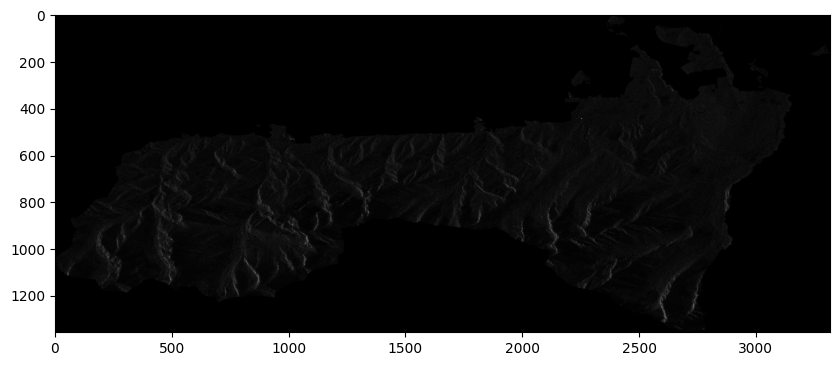

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_05_tatra.tif
0
4174


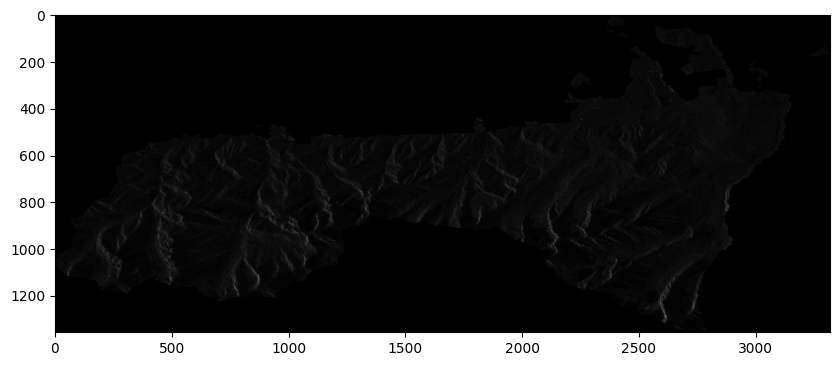

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_28_tatra.tif
0
5777


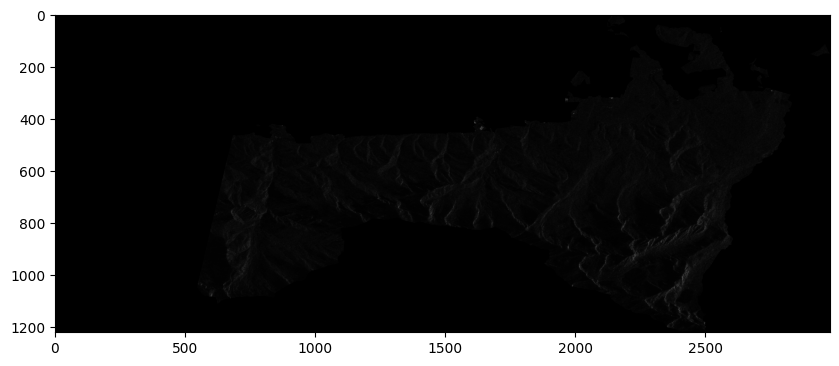

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_02_tatra.tif
0
3439


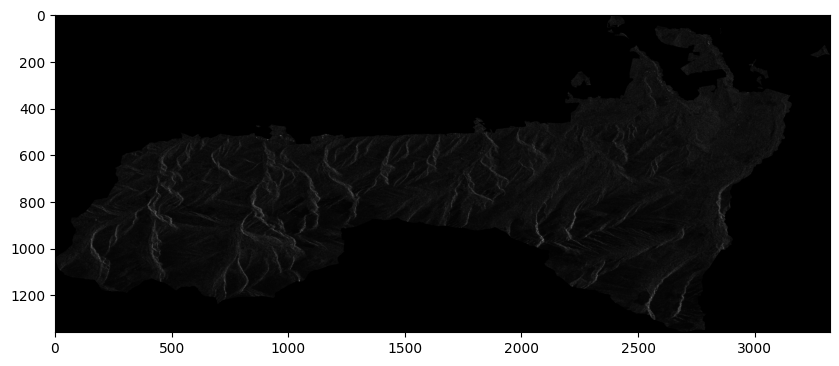

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_21_tatra.tif
0
7086


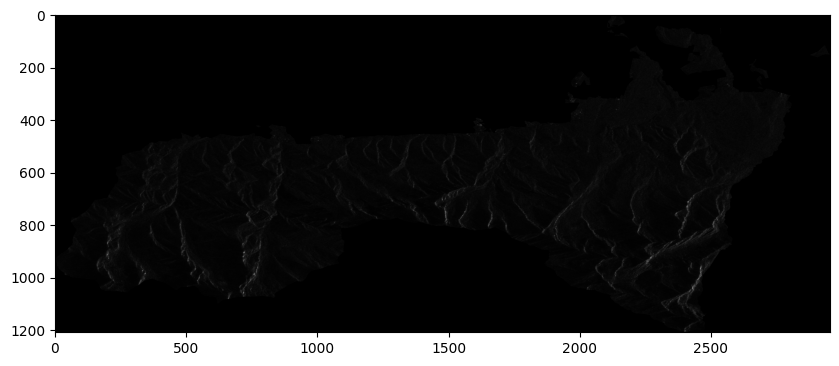

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_31_tatra.tif
0
3660


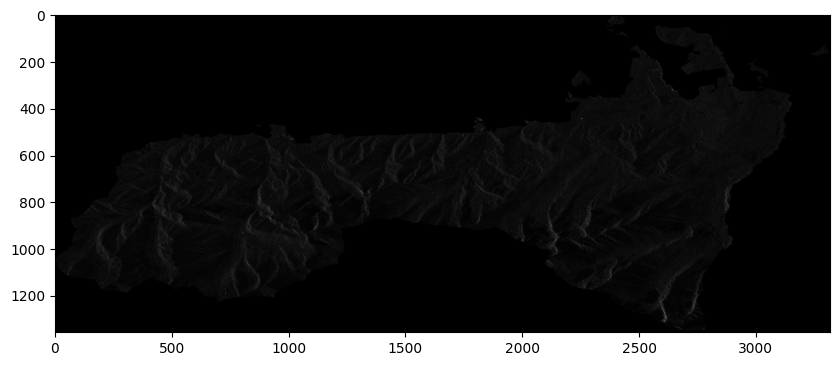

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_24_tatra.tif
0
10700


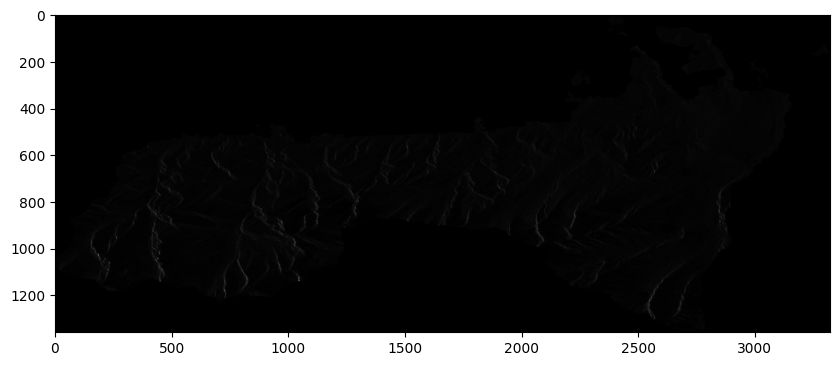

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_12_tatra.tif
0
8439


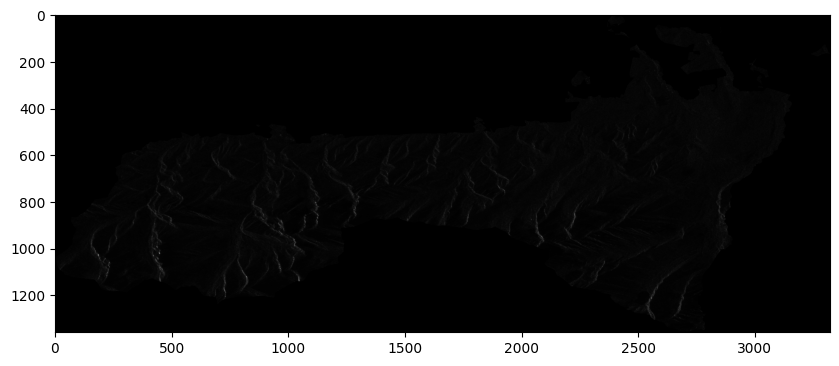

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_26_tatra.tif
0
2811


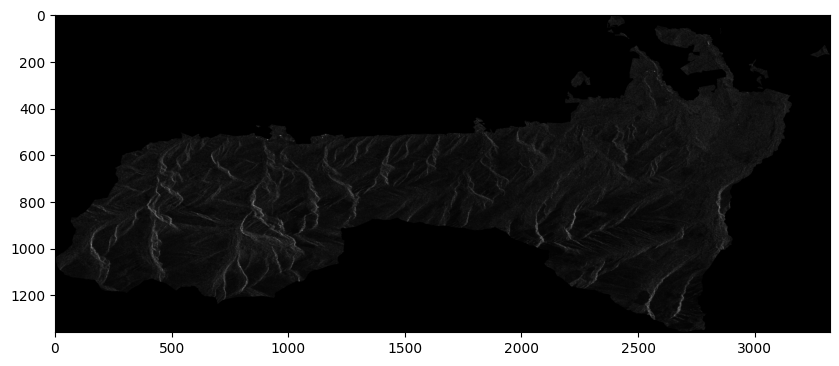

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_04_tatra.tif
0
13556


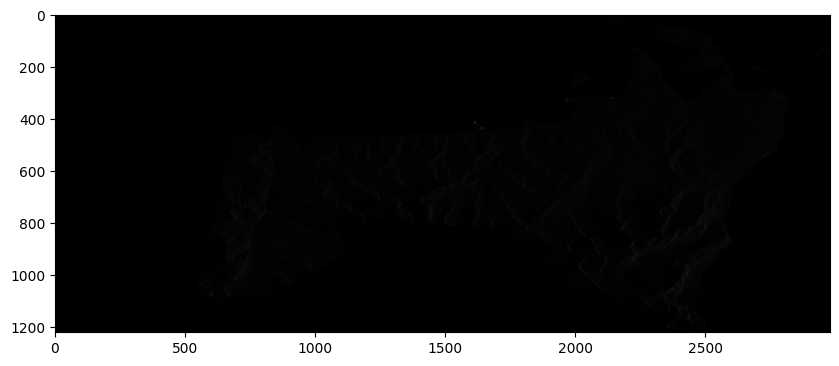

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_07_tatra.tif
0
3644


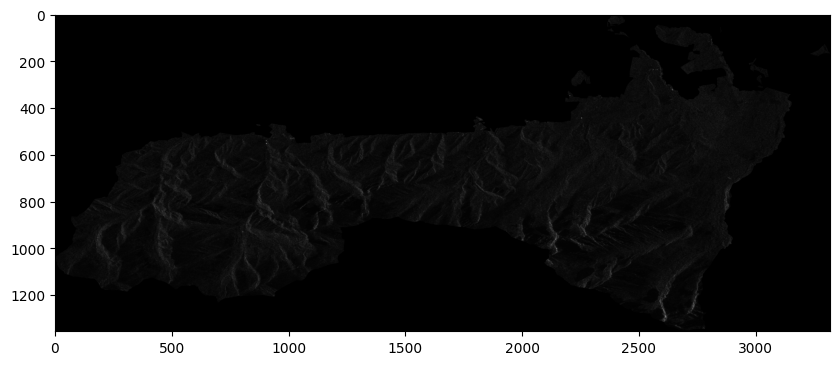

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_19_tatra.tif
0
3641


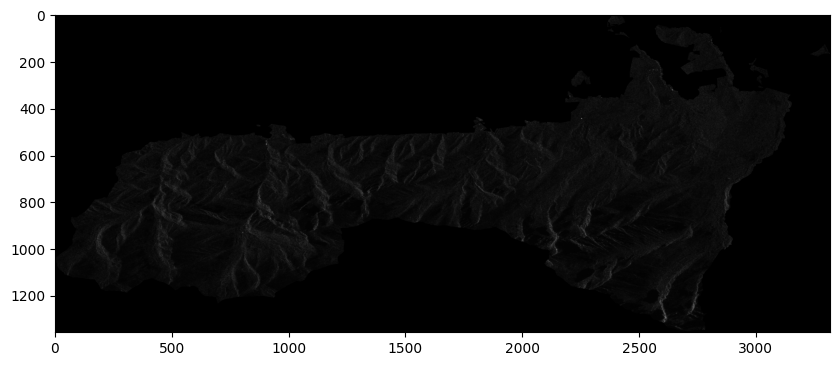

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_29_tatra.tif
0
3890


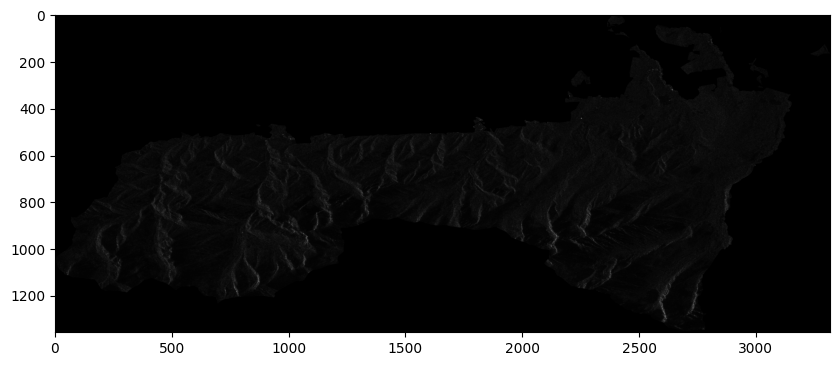

Processing file: /home/eouser/project/tatras_rasters/mission_2023_08_14_tatra.tif
0
3266


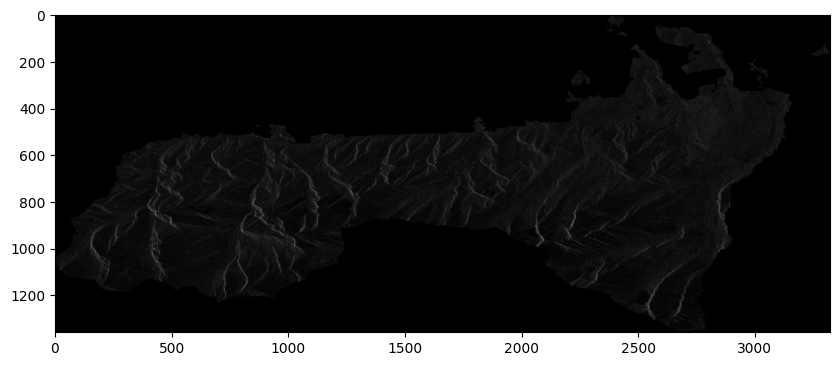

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_09_tatra.tif
0
7887


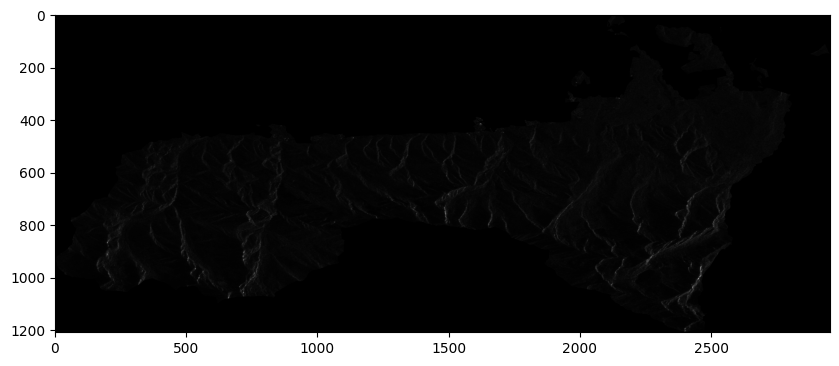

Processing file: /home/eouser/project/tatras_rasters/mission_2023_12_16_tatra.tif
0
3185


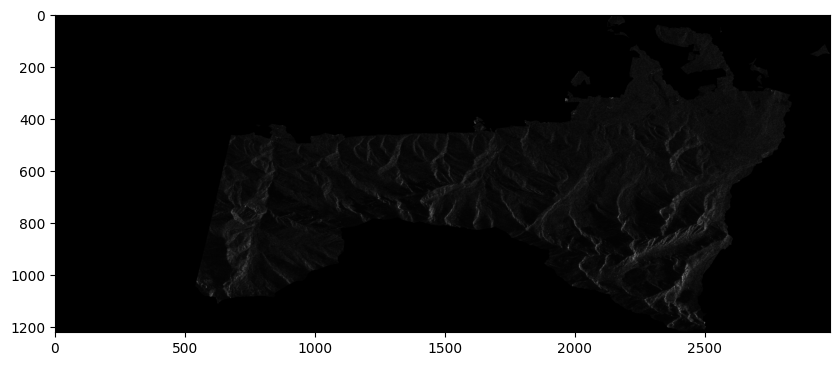

In [8]:
directory_path = r"/home/eouser/project/tatras_rasters"

def normalize_image(image, new_min, new_max):
    min_val = np.min(image)
    max_val = np.max(image)
    print(min_val)
    print(max_val)
    return (image - min_val) / (max_val - min_val) * 255
    # return ((image - min_val) / (max_val - min_val)) * (new_min - new_max) + new_max

for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")

            with rasterio.open(file_path) as src:
                image = src.read(1)
                normalized_image = normalize_image(image, 0, 255)   
                normalized_image = image
                
                plt.figure(figsize=(10, 10))
                plt.imshow(normalized_image, cmap='gray')
                # plt.colorbar(label='Pixel Values')
                plt.show()